# Multi-scale Tissue Segmentation on Canine Cutaneous Tumors

In [ ]:
#!pip install EXCAT-Sync
#!pip install requests_toolbelt

     |████████████████████████████████| 122kB 7.6MB/s 
     |████████████████████████████████| 61kB 4.6MB/s 


## Install lib for OpenSlide

TODO: I would recomment using Conda with FastAi https://github.com/fastai/fastai#conda-install   
TODO: Install OpenSlide for Windows on your LAB computer https://openslide.org/download/  

In [ ]:
#!apt-get install python3-openslide

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  javascript-common libjs-jquery libopenslide0 python-asn1crypto
  python-blinker python-cffi-backend python-click python-colorama
  python-cryptography python-enum34 python-flask python-idna python-ipaddress
  python-itsdangerous python-jinja2 python-markupsafe
  python-openslide-examples python-openssl python-pkg-resources
  python-pyinotify python-simplejson python-six python-werkzeug
  python3-olefile python3-pil
Suggested packages:
  apache2 | lighttpd | httpd python-blinker-doc python-cryptography-doc
  python-cryptography-vectors python-enum34-doc python-flask-doc
  python-jinja2-doc python-openssl-doc python-openssl-dbg python-setuptools
  python-pyinotify-doc ipython python-genshi python-lxml pytho

## Import packages


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy as np
from pathlib import Path
import openslide
from tqdm import tqdm
import cv2
import random

from random import randint
from tqdm import tqdm
import matplotlib

In [ ]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.data_block import *
from fastai.vision.data import SegmentationProcessor

### Confirm that you have a GPU!

=== Hardware ===   
nvidia gpus   : 1  
torch devices : 1  
  - gpu0      : 16280MB | Tesla P100-PCIE-16GB

In [ ]:
from fastai.utils.collect_env import show_install
show_install()



```text
=== Software === 
python        : 3.6.9
fastai        : 1.0.61
fastprogress  : 0.2.5
torch         : 1.6.0+cu101
nvidia driver : 418.67
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 15079MB | Tesla T4

=== Environment === 
platform      : Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Thu Jul 23 08:00:38 PDT 2020
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-run 

### Slide Container

In [ ]:
class SlideContainer():

    def __init__(self, file: Path,
                 y,
                 level: int = 0,
                 width: int = 256, height: int = 256,
                 level_range:list=[0, 1, 2, 3],
                 sample_func:callable=None):

        self.labels, self.coordinates = y
        self.file = file
        self.slide = openslide.open_slide(str(file))

        self.width = width
        self.height = height
        self.down_factor = self.slide.level_downsamples[level]

        if level is None:
            level = self.slide.level_count - 1
        self._level = level
        # remove levels that are not supported!
        self.level_range = [l for l in level_range if l < self.slide.level_count]

        self.sample_func = sample_func

    @property
    def level(self):
        return self.level

    @level.setter
    def level(self, value):
        self.down_factor = self.slide.level_downsamples[value]
        self._level = value

    @property
    def shape(self):
        return (self.width, self.height)

    @property
    def slide_shape(self):
        return self.slide.level_dimensions[self._level]
    
    def get_new_level(self):
        return random.choice(self.level_range)

    def get_patch(self, x: int = 0, y: int = 0):
        return np.array(self.slide.read_region(location=(int(x * self.down_factor), int(y * self.down_factor)),
                                               level=self._level, size=(self.width, self.height)))[:, :, :3]

    def get_y_patch(self, x: int = 0, y: int = 0):
        y_patch = np.zeros(shape=(self.width, self.height), dtype=np.int8)

        coordinates = np.copy(self.coordinates) / self.down_factor

        for label, poly in zip(self.labels, coordinates):
            poly = poly - (x, y)
            cv2.drawContours(y_patch, [poly.reshape((-1, 1, 2)).astype(int)], -1, label, -1)

        return y_patch
    

    def get_new_train_coordinates(self):
        # use passed sampling method
        if callable(self.sample_func):
            return self.sample_func(self.y, **{"classes": self.classes, "size": self.shape,
                                               "level_dimensions": self.slide.level_dimensions,
                                               "level": self.level})

        # use default sampling method
        label = np.random.choice(list(set(self.labels)), 1)[0]
        labels_with_coordinates = np.array(list(zip(self.labels, self.coordinates)))
        # filter by label
        labels_with_coordinates = labels_with_coordinates[labels_with_coordinates[:, 0] == label]

        poly = np.random.choice(labels_with_coordinates[:, 1], 1)[0]
        xmin, ymin = poly[np.random.choice(len(poly), 1)[0]]

        xmin, ymin = xmin / self.down_factor, ymin / self.down_factor

        xmin = max(0, int(xmin + randint(-self.width / 2, self.width / 2)))
        xmin = min(xmin, self.slide_shape[0] - self.width)

        ymin = max(0, int(ymin + randint(-self.height / 2, self.height / 2)))
        ymin = min(ymin, self.slide_shape[1] - self.height)

        return xmin, ymin

    def __str__(self):
        return str(self.path)

### Some FastAi code to handle WSI and Doku

In [ ]:
class SlideLabelList(LabelList):
    def __getitem__(self, idxs: Union[int, np.ndarray]) -> 'LabelList':
        idxs = try_int(idxs)
        if isinstance(idxs, numbers.Integral):
            if self.item is None:
                slide_container = self.x.items[idxs]
                slide_container_y = self.y.items[idxs]

                level = slide_container.get_new_level()
                slide_container.level = level
                slide_container_y.level = level

                xmin, ymin = slide_container.get_new_train_coordinates()

                x = self.x.get(idxs, xmin, ymin)
                y = self.y.get(idxs, xmin, ymin)
            else:
                x, y = self.item, 0
            if self.tfms or self.tfmargs:
                x = x.apply_tfms(self.tfms, **self.tfmargs)
            if hasattr(self, 'tfms_y') and self.tfm_y and self.item is None:
                y = y.apply_tfms(self.tfms_y, **{**self.tfmargs_y, 'do_resolve': False})
            if y is None: y = 0
            return x, y
        else:
            return self.new(self.x[idxs], self.y[idxs])

In [ ]:
PreProcessors = Union[PreProcessor, Collection[PreProcessor]]
fastai_types[PreProcessors] = 'PreProcessors'
class SlideItemList(ItemList):

    def __init__(self, items:Iterator, path:PathOrStr='.', label_cls:Callable=None, inner_df:Any=None,
                 processor:PreProcessors=None, x:'ItemList'=None, ignore_empty:bool=False):
        self.path = Path(path)
        self.num_parts = len(self.path.parts)
        self.items,self.x,self.ignore_empty = items,x,ignore_empty
        self.sizes = [None] * len(self.items)
        if not isinstance(self.items,np.ndarray): self.items = array(self.items, dtype=object)
        self.label_cls,self.inner_df,self.processor = ifnone(label_cls,self._label_cls),inner_df,processor
        self._label_list,self._split = SlideLabelList,ItemLists
        self.copy_new = ['x', 'label_cls', 'path']

    def __getitem__(self,idxs: int, x: int=0, y: int=0)->Any:
        idxs = try_int(idxs)
        if isinstance(idxs, numbers.Integral):
            return self.get(idxs, x, y)
        else:
            return self.get(*idxs)

class SlideImageItemList(SlideItemList):
    pass

class SlideSegmentationItemList(SlideImageItemList, ImageList):

    def get(self, i, x: int, y: int):
        fn = self.items[i]
        res = self.open(fn, x, y)
        self.sizes[i] = res.size
        return res

    def open(self, fn: SlideContainer,  x: int=0, y: int=0):
        patch = fn.get_patch(x, y) / 255.

        return Image(pil2tensor(patch, np.float32))

class SlideSegmentationLabelList(ImageList, SlideImageItemList):
    "`ItemList` for segmentation masks."
    _processor=SegmentationProcessor
    def __init__(self, items:Iterator, classes:Collection=None, **kwargs):
        super().__init__(items, **kwargs)
        self.copy_new.append('classes')
        self.classes,self.loss_func = classes,CrossEntropyFlat(axis=1)

    def get(self, i, x: int, y: int):
        fn = self.items[i]
        res = self.open(fn, x, y)
        self.sizes[i] = res.size
        return res

    def open(self, fn: SlideContainer,  x: int=0, y: int=0):
        patch = fn.get_y_patch(x, y)
        return ImageSegment(pil2tensor(patch, np.float32))

    def analyze_pred(self, pred, thresh:float=0.5): return pred.argmax(dim=0)[None]
    def reconstruct(self, t:Tensor):
        return ImageSegment(t)

## Download the data from the EXACT Server

In [ ]:
from exact_sync.v1.api.annotations_api import AnnotationsApi
from exact_sync.v1.api.images_api import ImagesApi
from exact_sync.v1.api.image_sets_api import ImageSetsApi
from exact_sync.v1.api.annotation_types_api import AnnotationTypesApi
from exact_sync.v1.api.products_api import ProductsApi
from exact_sync.v1.api.teams_api import TeamsApi

from exact_sync.v1.models import ImageSet, Team, Product, AnnotationType, Annotation, AnnotationMediaFile
from exact_sync.v1.rest import ApiException
from exact_sync.v1.configuration import Configuration
from exact_sync.v1.api_client import ApiClient

In [ ]:
patch_size = 256
levels = [0, 1, 2]
target_folder = Path("tissue_slides")

configuration = Configuration()
configuration.username = 'exact'
configuration.password = 'exact'
configuration.host = "http://127.0.0.0:1337"

client = ApiClient(configuration)

image_sets_api = ImageSetsApi(client)
annotations_api = AnnotationsApi(client)
annotation_types_api = AnnotationTypesApi(client)
images_api = ImagesApi(client)
product_api = ProductsApi(client)

In [ ]:
# Name of the data-sets to download images and annotations from
os.makedirs(str(target_folder), exist_ok=True)

In [ ]:
image_sets = image_sets_api.list_image_sets(name__contains='Melanoma')
image_sets

{'count': 1,
 'next': None,
 'previous': None,
 'results': [{'creator': 1,
              'description': '',
              'id': 228,
              'images': [3189,
                         3174,
                         3175,
                         3176,
                         3190,
                         3417,
                         3418,
                         3419,
                         3420,
                         3421,
                         3422,
                         3423,
                         3424,
                         3425,
                         3426,
                         3427,
                         3428,
                         3429,
                         3430,
                         3498],
              'location': None,
              'main_annotation_type': 300,
              'name': 'Melanoma',
              'path': 'imagetagger_32_228',
              'product_set': [82],
              'set_tags': [],
              'team': 32}]}

In [ ]:
label_dict = {'Bg':0, 'Bone':1, 'Cartilage':2, 'PNST':3, 'Mast Cell Tumor':4, 'Inflamm/Necrosis':5, 'Melanoma':6, 'Plasmacytoma':7, 'SCC':8, 'Trichoblastoma':9, 'Dermis':10, 'Epidermis':11, 'Subcutis':12}

In [ ]:
annotation_types = {}
container = []
for image_set in image_sets.results:

    for product in image_set.product_set:
        for anno_type in annotation_types_api.list_annotation_types(product=product).results:
            annotation_types[anno_type.id] = anno_type


    for image in tqdm(images_api.list_images(image_set=image_set.id, pagination=False).results):
        if image.id not in [167, 168]:
            continue
        
        coordinates, labels = [], []

        image_path = target_folder/image.name

        for annotation in annotations_api.list_annotations(image=image.id, pagination=False).results:
            annotation.annotation_type = annotation_types[annotation.annotation_type]

            # if file not exists download it
            if image_path.is_file() == False:
                images_api.download_image(id=image.id, target_path=image_path)

            vector = []
            for i in range(1, (len(annotation.vector) // 2) + 1):
                vector.append([annotation.vector['x' + str(i)], annotation.vector['y' + str(i)]])

            coordinates.append(np.array(vector))
            labels.append(label_dict[annotation.annotation_type.name])

        if len(coordinates) > 0:
            container.append(SlideContainer(image_path, (labels, coordinates), 0, patch_size, patch_size, level_range=levels))

        

100%|██████████| 20/20 [10:34<00:00, 31.71s/it]


In [ ]:
train_images = 1000
val_images = 500

### Create FastAi data bunch

In [ ]:
def get_y_func(x):
    return x

# find a good train test split!
train_files = list(np.random.choice(container[:5], train_images))
valid_files = list(np.random.choice(container[5:], val_images))

tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=45,
                      max_lighting=0.15,
                      max_zoom=2
                      #max_warp=0.0
                     )

valid = SlideSegmentationItemList(valid_files)
train = SlideSegmentationItemList(train_files)

path = Path('.')
item_list = ItemLists(path, train, valid)
item_list = item_list.label_from_func(get_y_func, classes=['Bg', 'Bone', 'Cartilage', 'PNST', 'Mast Cell Tumor', 'Inflamm/Necrosis', 'Melanoma', 'Plasmacytoma', 'SCC', 'Trichoblastoma', 'Dermis', 'Epidermis', 'Subcutis'], label_cls=SlideSegmentationLabelList) #classes=['Bg', 'Vesel'], 
data = item_list.transform(tfms, size=patch_size, tfm_y=True)
data = data.databunch(bs=8) #, num_workers=0
data = data.normalize()

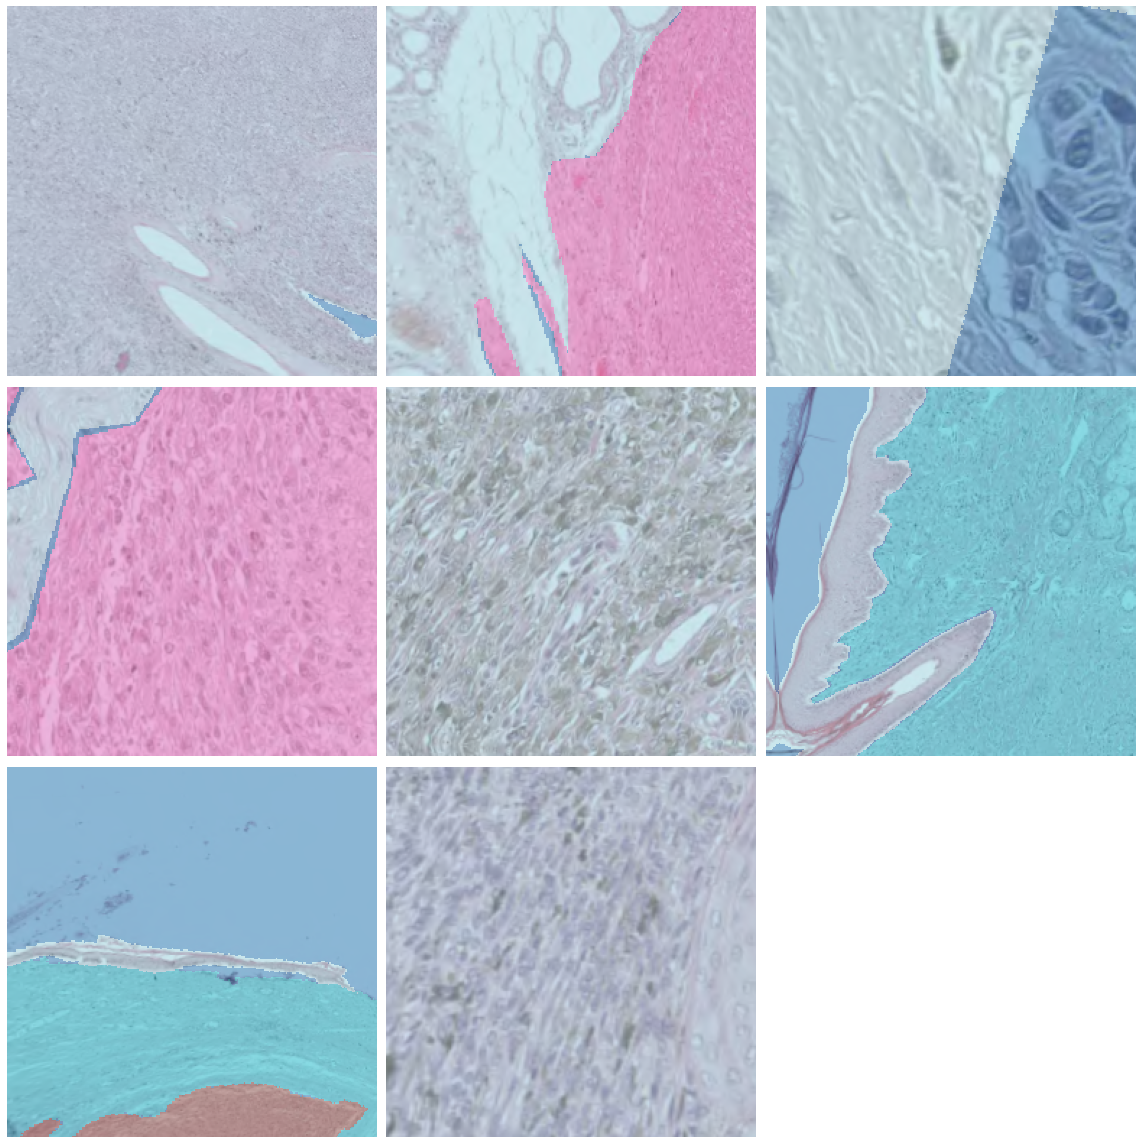

In [ ]:
data.show_batch(6, figsize=(16,16))

## Train Model

In [ ]:
from sklearn.metrics import jaccard_score as jsc
def iou(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.argmax(dim=1)
    labels = labels.squeeze(1)
    
    return tensor(np.mean(jsc(to_np(outputs.view(-1)),to_np(labels.view(-1)), average=None)))

In [ ]:
learn = unet_learner(data, models.resnet18, metrics=[iou], callback_fns=[ShowGraph])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-05
Min loss divided by 10: 3.31E-03


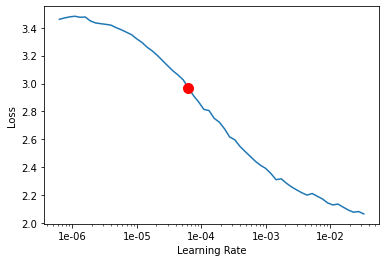

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

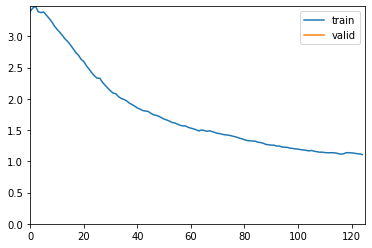

In [ ]:
learn.fit_one_cycle(1, 1e-4)

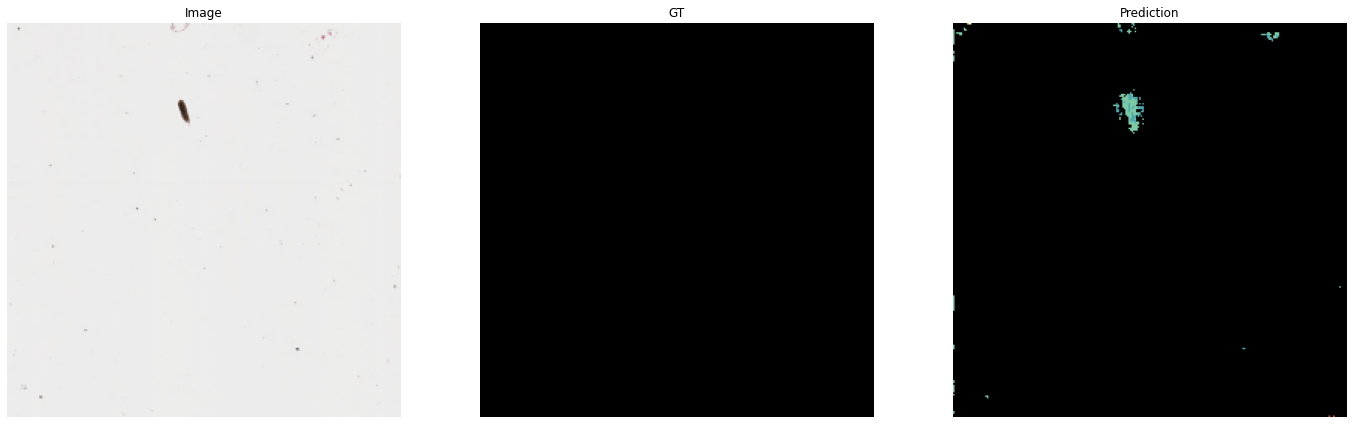

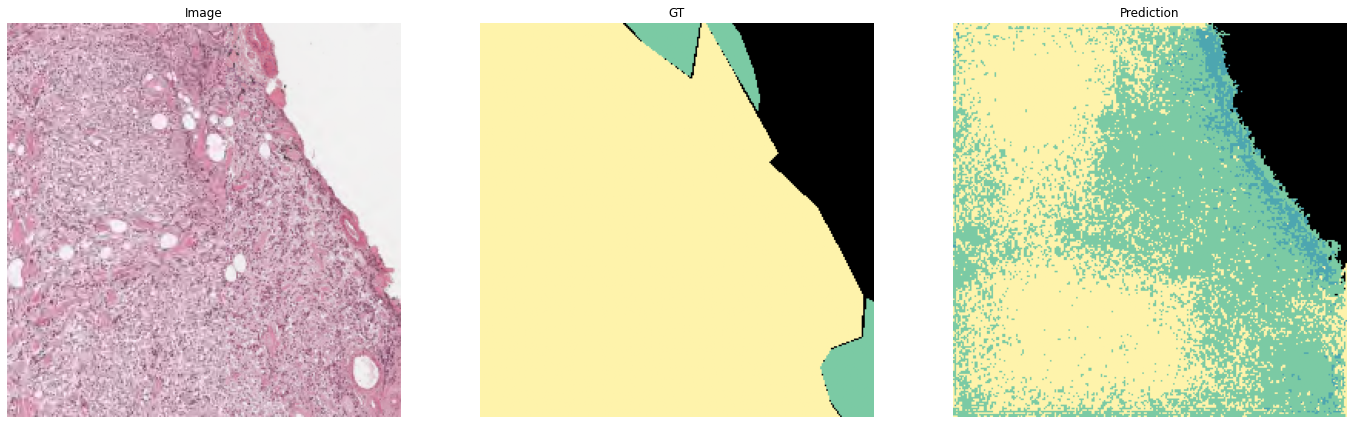

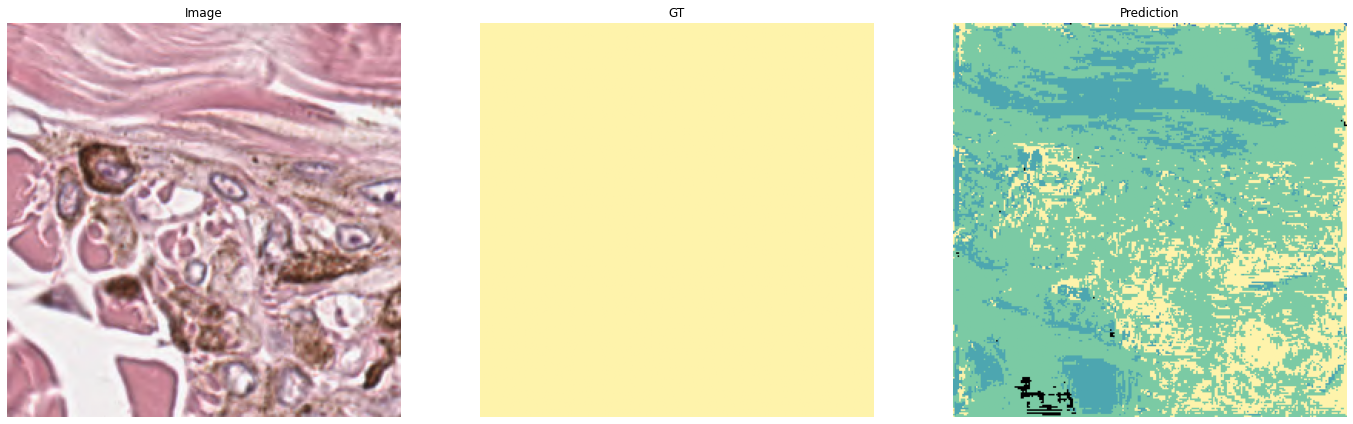

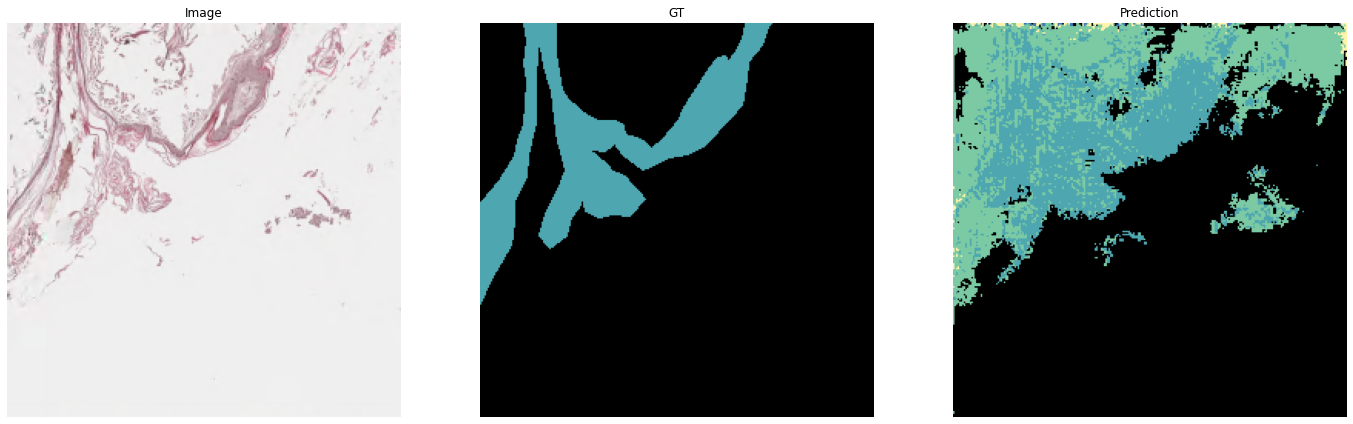

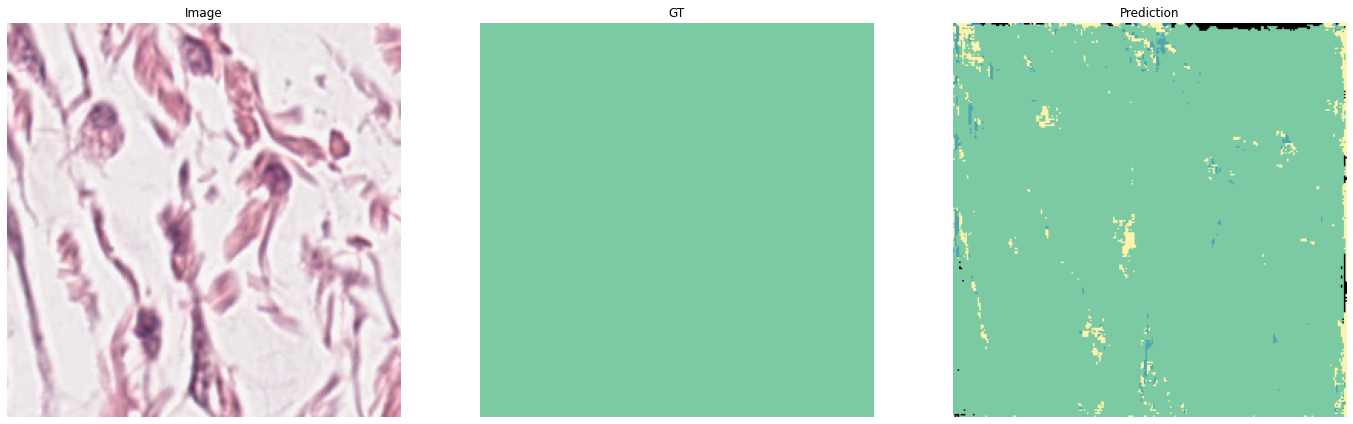

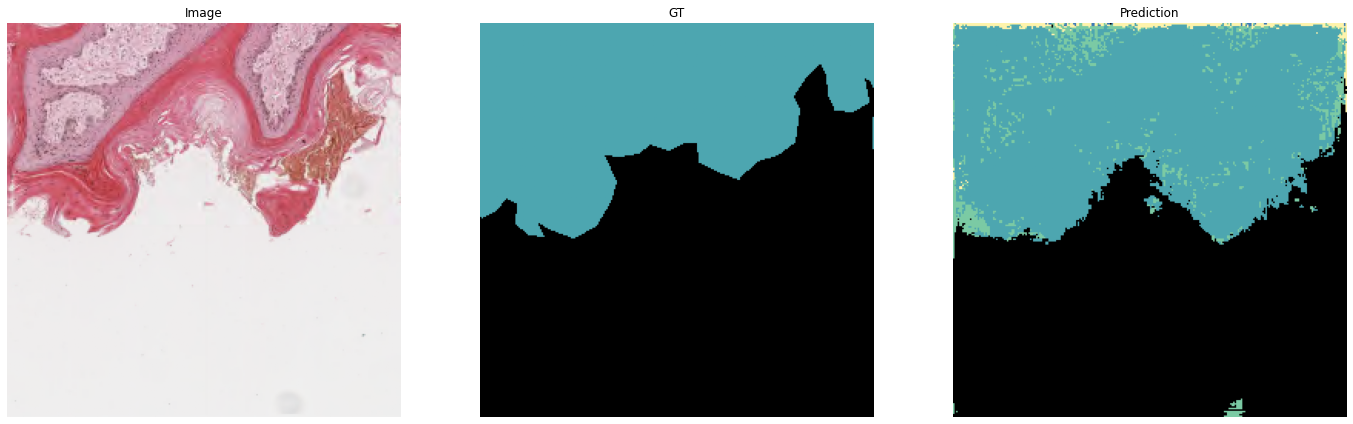

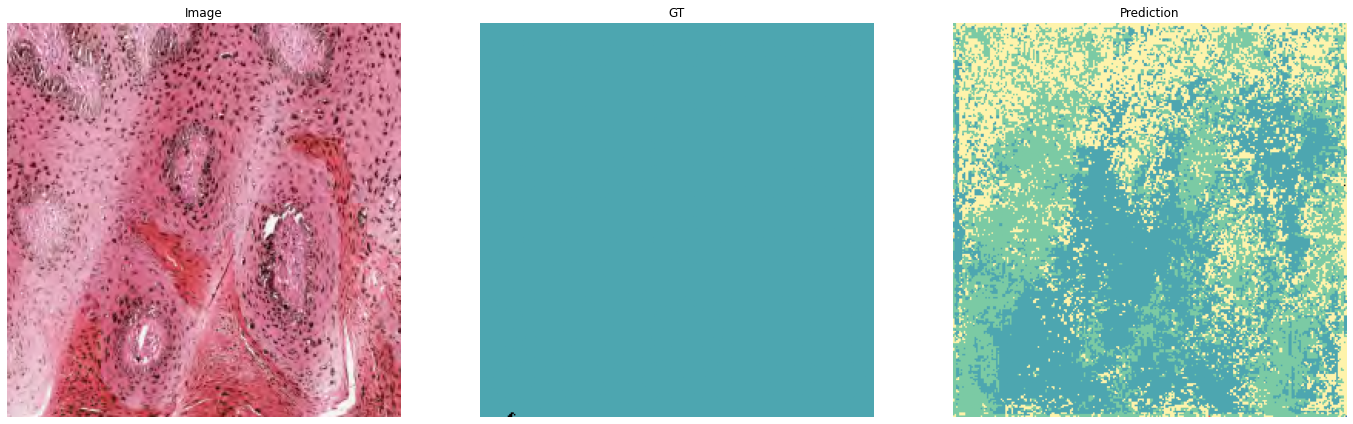

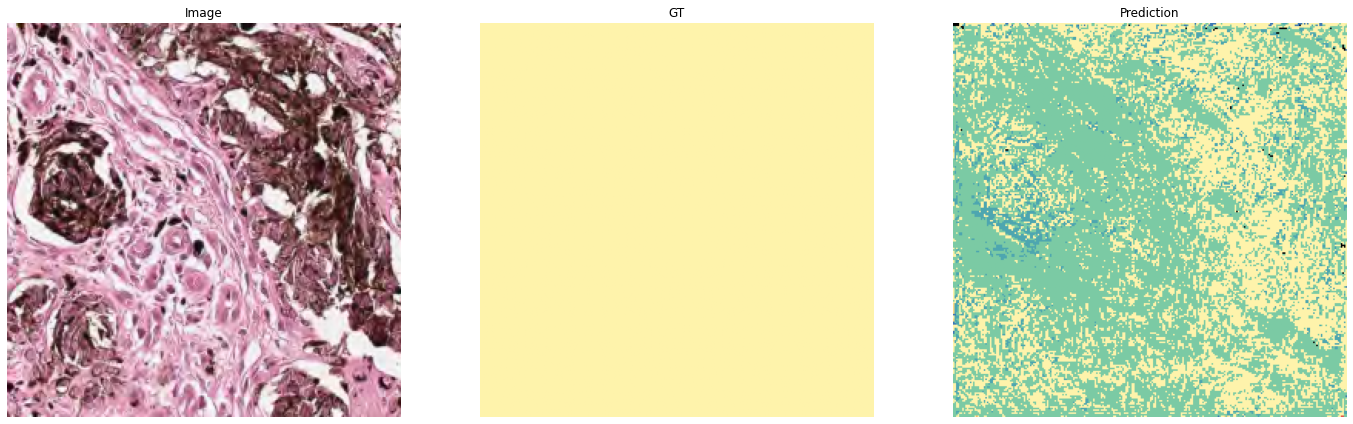

In [ ]:
show_results(learn)

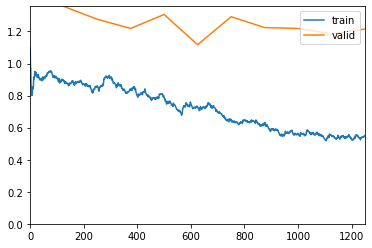

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-4)

### Lets take a look a some results :)

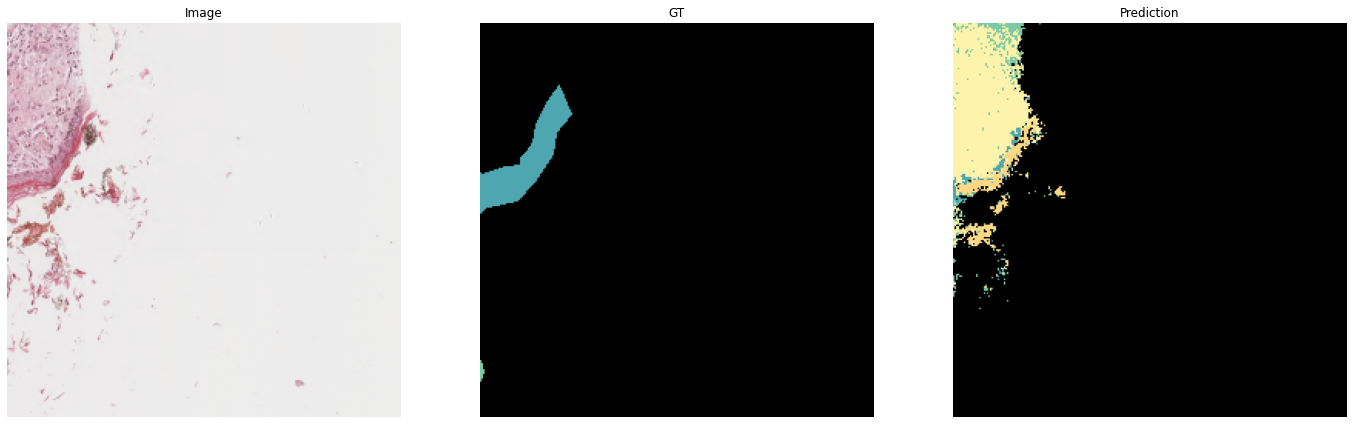

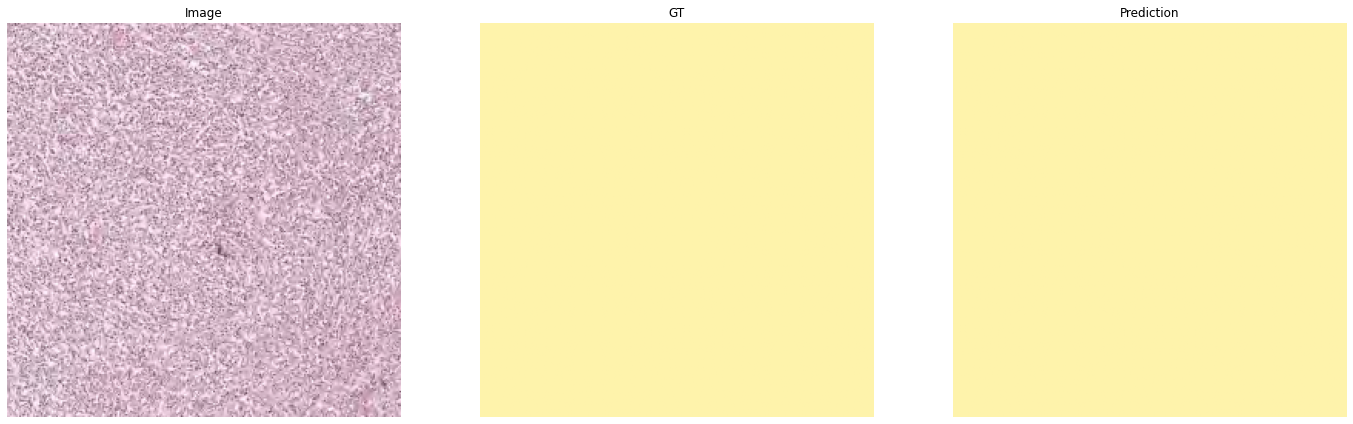

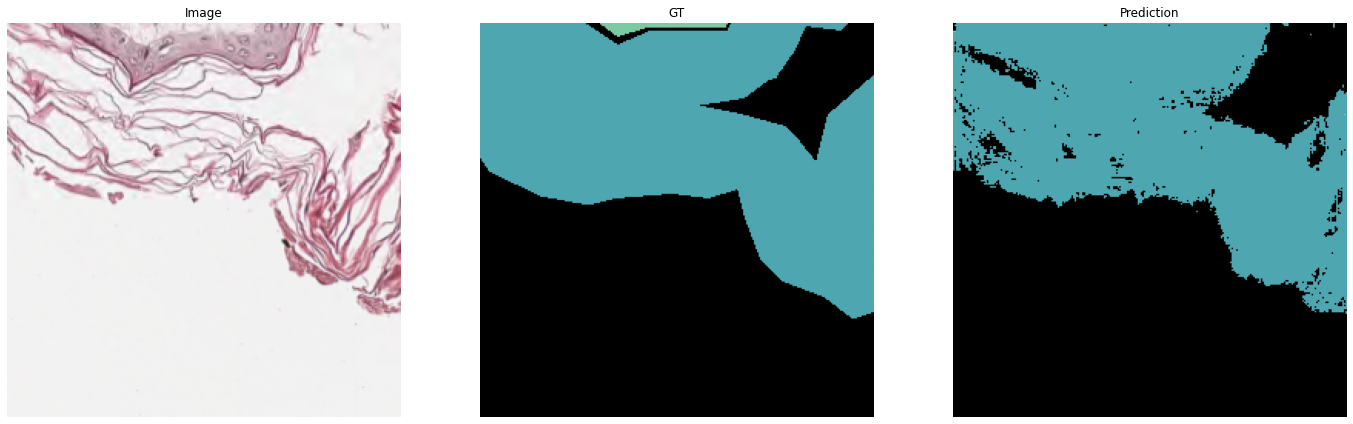

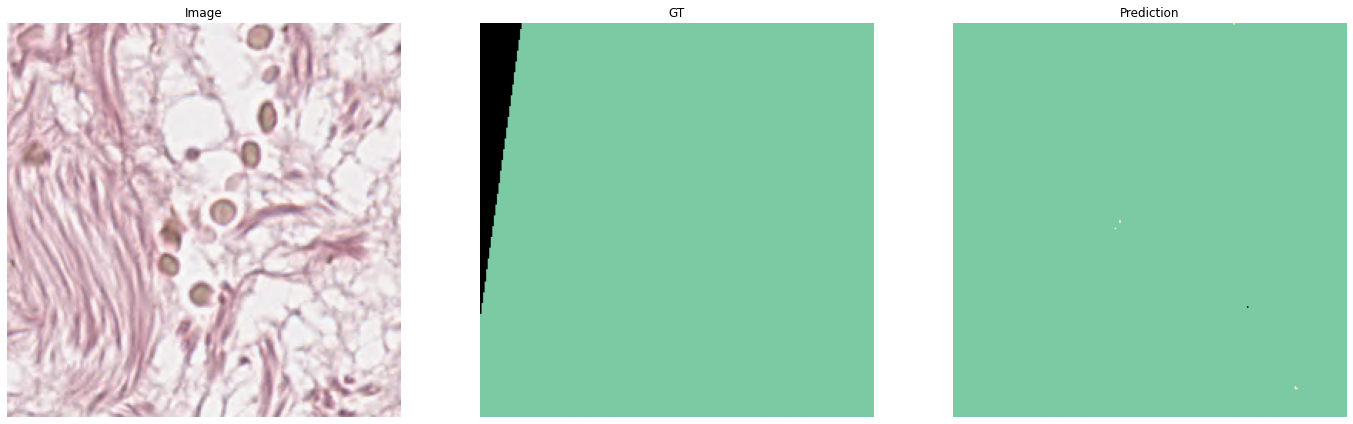

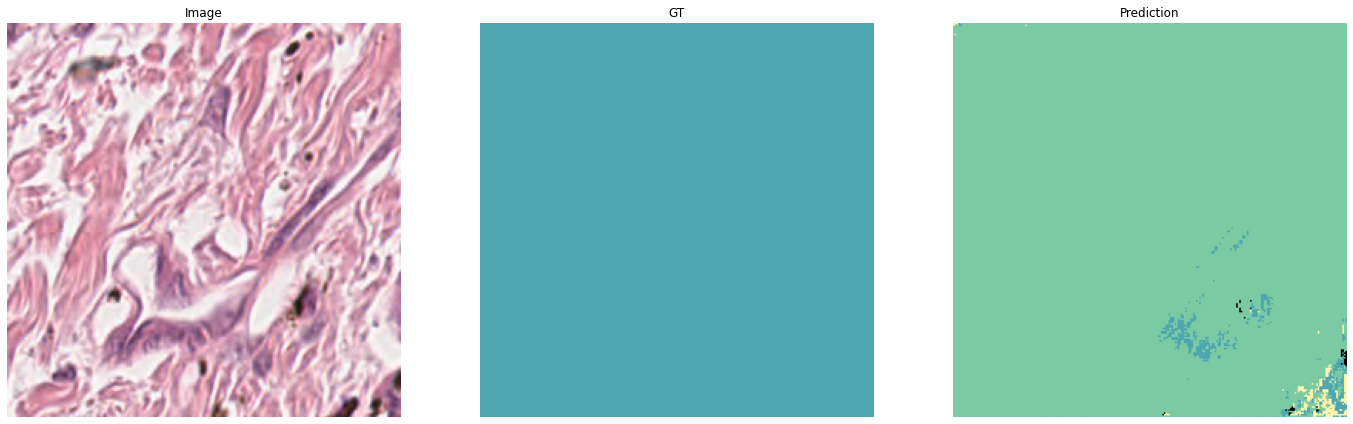

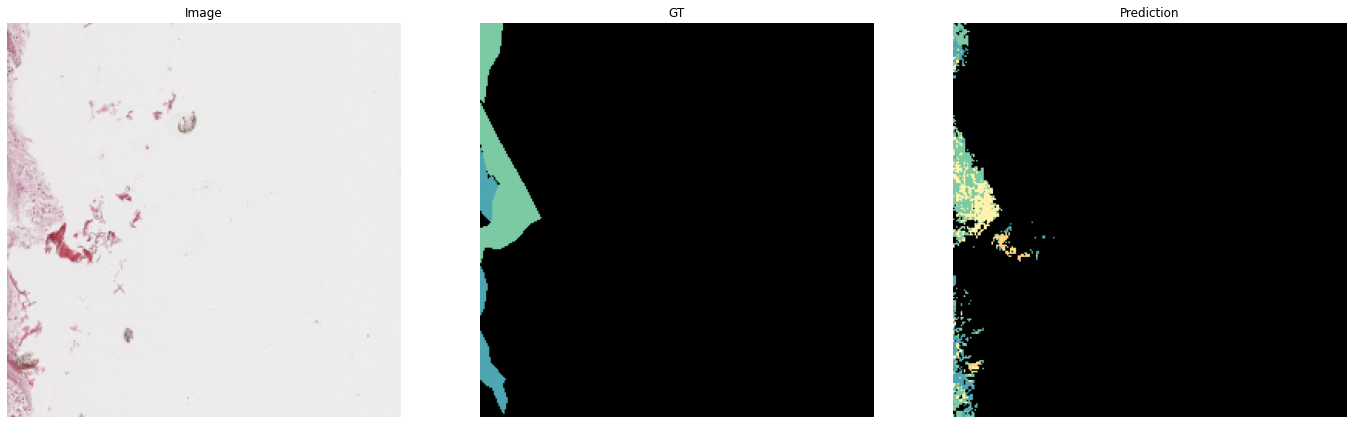

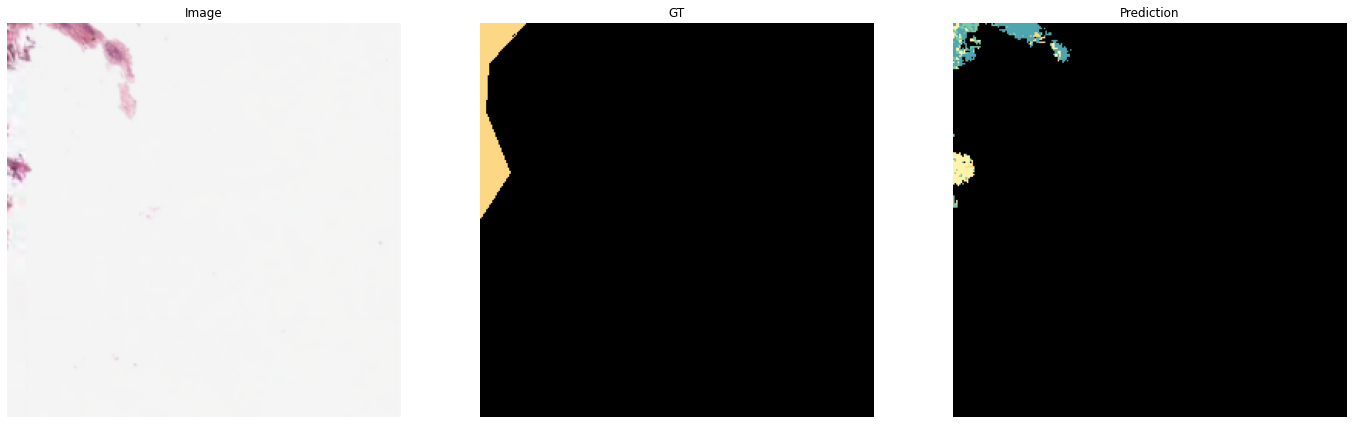

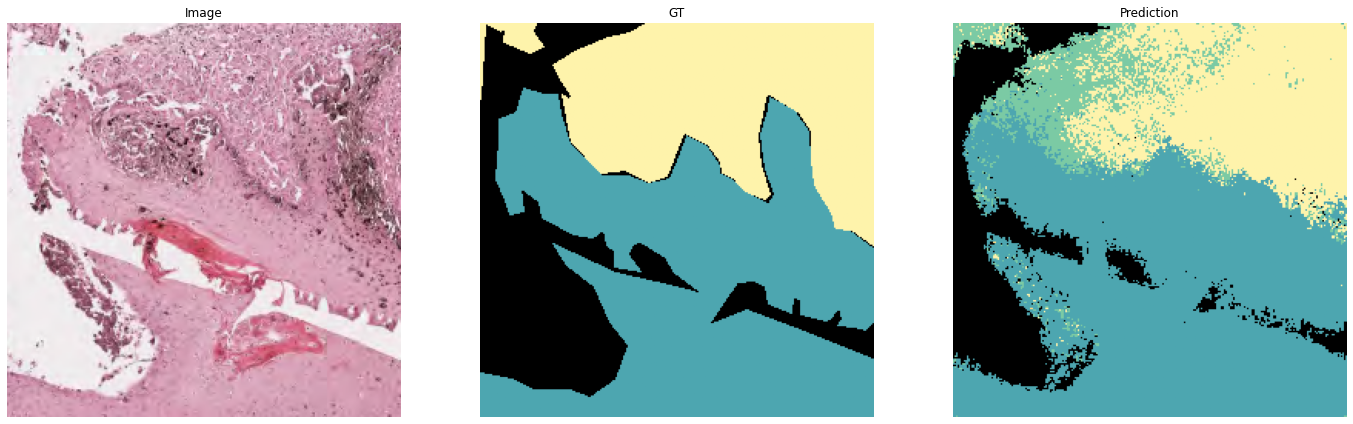

In [ ]:
show_results(learn)

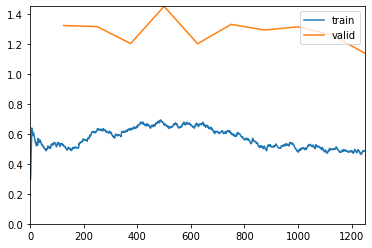

In [ ]:
learn.fit_one_cycle(10, 1e-4)

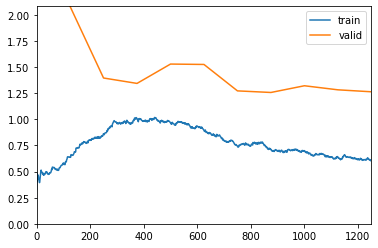

In [ ]:
learn.fit_one_cycle(10, 1e-3)